In [1]:
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.lines import lineStyles
from matplotlib_venn import venn3
import pandas as pd
from upsetplot import from_contents, UpSet
from pyteomics import electrochem
import Levenshtein
import os
from Bio import SeqIO
from Bio.PDB import PDBParser
import numpy as np
from itertools import pairwise

In [2]:

%matplotlib inline

# Read data

In [3]:
project = '/home/ismael/palaeoproteomics/BLG'
benchmark_table = pd.read_csv(os.path.join(project, 'benchmark_table.csv'), header=0)
benchmark_table['Run_extended'] = benchmark_table['Engine'] + ' ' + benchmark_table['Digestion'] + ' ' + benchmark_table['DB']
benchmark_table['Run_settings'] = benchmark_table['Digestion'] + ' ' + benchmark_table['DB']
benchmark_table.to_csv(os.path.join(project, 'benchmark_table.csv'), index=False)

In [4]:
psm_data_file = os.path.join(project, 'analysis_results', 'psms_data.csv')
psm_data_df = pd.read_csv(psm_data_file, index_col=0)
psm_data_df['Run_extended'] = psm_data_df['Engine'] + ' ' + psm_data_df['Digestion'] + ' ' + psm_data_df['DB']

psm_counts_file = os.path.join(project, 'analysis_results', 'psms_counts', 'psms_counts.csv')
psm_counts_df = pd.read_csv(psm_counts_file)

position_counts_file = os.path.join(project, 'analysis_results', 'dbsearch_position_letters.csv')
position_counts = pd.read_csv(position_counts_file)

In [5]:
samples = ['0 days', '4 days', '128 days']
sample_names = {'N0000': '0 days', 'N0040': '4 days' , 'N1280': '128 days'}
# Sometimes the samples names order will be automatically put in order,
# and the 4 days will appear before 128 days, this is to put it in order
manual_order = [0, 2, 1]

psm_data_df['Sample'] = psm_data_df['Sample'].map(sample_names)
psm_counts_df['Sample'] = psm_counts_df['Sample'].map(sample_names)
position_counts['Sample'] = position_counts['Sample'].map(sample_names)

In [6]:
blga_fasta = os.path.join(project, 'bovin_blg', 'bovin_blgA.fasta')
blga_seq = list(SeqIO.parse(blga_fasta, format='fasta'))


# Set plotting variables

In [7]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
# plt.rcParams['axes.facecolor'] = 'whitesmoke'

samples_markers = {
    '0 days': 'o', '4 days': '^', '128 days': 'P'
}
samples_colors = {
    '0 days': '#d4c611', '4 days': '#2edaf7', '128 days': '#b641c5'
}

samples_greyscale = {
    '0 days': '#767676', '4 days': '#a7a7a7', '128 days': '#d8d8d8'
}

settings_colors = {
    'Tryptic DB1': '#5ba300',
    'Semi-tryptic DB1': '#5ba300',
    'Non-specific DB1': '#5ba300',
    'Tryptic DB2': '#b51963',
    'Semi-tryptic DB2': '#b51963',
    'Non-specific DB2': '#b51963',
}

db_colors = {
    'DB1': '#5ba300',
    'DB2': '#b51963'
}
settings_linetype = {
    'Tryptic DB1': 'solid',
    'Semi-tryptic DB1': 'dashed',
    'Non-specific DB1': 'dotted',
    'Tryptic DB2': 'solid',
    'Semi-tryptic DB2': 'dashed',
    'Non-specific DB2': 'dotted',
}

digestion_dashes = {
    'Tryptic': '',
    'Semi-tryptic': [5,2],
    'Non-specific': [1,2],
}

engine_shade = {
    'pFind': '#5ba300',
    # 'Fragpipe': '#b51963',
    'Metamorpheus': '#0073e6',
    'Open-Fragpipe': '#b51963',
    'Narrow-Fragpipe': '#af8e9e',
    'MaxQuant': '#73735F',
    'Mascot': '#b9b9b9'
}

engine_linetype = {
    'pFind': 'solid',
    'Metamorpheus': 'dashed',
    'Fragpipe': 'dotted',
}


## Report # of PSMs

In [8]:
psms_report = (psm_counts_df
    .query('fdr == 0.05 or (fdr < 0.010001 and fdr > 0.00999)')
    .sort_values(['Run_id', 'Sample'])
    .loc[:,['Run_id', 'Engine', 'Digestion', 'DB', 'Sample', 'fdr', 'n_psm', 'Search']]
    .astype({'n_psm': 'int32'})
    .pivot(index=['Run_id', 'Engine', 'Digestion', 'DB', 'Sample', 'Search'], columns='fdr', values='n_psm')
    .reset_index()
 )

psms_report['Sample_tmp'] = psms_report['Sample'].map({'0 days': 'N0000', '4 days': 'N0040', '128 days': 'N1280'})
psms_report.sort_values(['Sample_tmp', 'Digestion', 'DB']).rename(columns={0.01: 'FDR 0.01', 0.05: 'FDR 0.05'})
psms_report.columns = ['Run_id', 'Engine', 'Digestion',
                       'DB', 'Sample', 'Search', 'FDR 0.01',
                       'FDR 0.05', 'Sample_tmp']
psms_report = (
    psms_report
    .pivot(index=['Run_id', 'Digestion', 'DB', 'Engine', 'Search'], columns='Sample_tmp', values=['FDR 0.01', 'FDR 0.05'])
    .fillna(0)
    .astype('int32')
    .reset_index()
    .sort_values(['DB', 'Digestion', 'Search', 'Engine']))
psms_report.to_csv(os.path.join(project, 'analysis_results', 'psms_report.csv'), index=True)
psms_report

Run_id     Digestion   DB        Engine  Search  \
Sample_tmp                                                              
0           closed_fp_ns_db1  Non-specific  DB1      Fragpipe  Closed   
9              mascot_ns_db1  Non-specific  DB1        Mascot  Closed   
21                 mq_ns_db1  Non-specific  DB1      MaxQuant  Closed   
3                  fp_ns_db1  Non-specific  DB1      Fragpipe    Open   
15                 mm_ns_db1  Non-specific  DB1  Metamorpheus    Open   
27                 pf_ns_db1  Non-specific  DB1         pFind    Open   
1           closed_fp_st_db1  Semi-tryptic  DB1      Fragpipe  Closed   
11             mascot_st_db1  Semi-tryptic  DB1        Mascot  Closed   
23                 mq_st_db1  Semi-tryptic  DB1      MaxQuant  Closed   
5                  fp_st_db1  Semi-tryptic  DB1      Fragpipe    Open   
17                 mm_st_db1  Semi-tryptic  DB1  Metamorpheus    Open   
29                 pf_st_db1  Semi-tryptic  DB1         pFind    Open   
2            closed_fp_t_db1       Tryptic  DB1      Fragpipe  Closed   
13              mascot_t_db1       Tryptic  DB1        Mascot  Closed   
25                  mq_t_db1       Tryptic  DB1      MaxQuant  Closed   
7                   fp_t_db1       Tryptic  DB1      Fragpipe    Open   
19                  mm_t_db1       Tryptic  DB1  Metamorpheus    Open   
31                  pf_t_db1       Tryptic  DB1         pFind    Open   
10             mascot_ns_db2  Non-specific  DB2        Mascot  Closed   
22                 mq_ns_db2  Non-specific  DB2      MaxQuant  Closed   
4                  fp_ns_db2  Non-specific  DB2      Fragpipe    Open   
16                 mm_ns_db2  Non-specific  DB2  Metamorpheus    Open   
28                 pf_ns_db2  Non-specific  DB2         pFind    Open   
12             mascot_st_db2  Semi-tryptic  DB2        Mascot  Closed   
24                 mq_st_db2  Semi-tryptic  DB2      MaxQuant  Closed   
6                  fp_st_db2  Semi-tryptic  DB2      Fragpipe    Open   
18                 mm_st_db2  Semi-tryptic  DB2  Metamorpheus    Open   
30                 pf_st_db2  Semi-tryptic  DB2         pFind    Open   
14              mascot_t_db2       Tryptic  DB2        Mascot  Closed   
26                  mq_t_db2       Tryptic  DB2      MaxQuant  Closed   
8                   fp_t_db2       Tryptic  DB2      Fragpipe    Open   
20                  mm_t_db2       Tryptic  DB2  Metamorpheus    Open   
32                  pf_t_db2       Tryptic  DB2         pFind    Open   

           FDR 0.01             FDR 0.05              
Sample_tmp    N0000 N0040 N1280    N0000 N0040 N1280  
0              1537  1595   912     1666  1862  1164  
9              1506  1757   893     1689  1991  1036  
21             1183  1241   974     1336  1422  1233  
3              2621   652   718     2863   687  1516  
15                0  2382  1231        0  3067  2192  
27             4221  3967  2351     4796  5482  3067  
1              1371  1361   323     1525  1556   399  
11             1397  1625   231     1612  1836   280  
23             1153  1528   338     1292  1738   447  
5              2618   552   602     2874   644  1851  
17             1877  1983   289     2712  3064  1030  
29             4246  3403  1927     4726  5212  2328  
2               891   648    31      917   725    40  
13              949   668    46     1076   753    49  
25             1119   902   123     1119   902   123  
7              3930  3004   464     4639  3949   605  
19              748   466     6     1209   802   104  
31             4206  3938  1887     4666  5018  2258  
10             1093  1235   311     1377  1543   413  
22              710   900   264      852  1127   451  
4              2973  1493   417     3682  1839   666  
16             1467  1817   455     1791  2255   934  
28             3682  3123  1321     4283  4200  1662  
12             1109  1225   231     1344  1470   280  
24              719   931    66     

In [9]:
psms_bar = (psm_counts_df
 .query('(fdr < 0.010001 and fdr > 0.00999)')
 .sort_values(['Run_id', 'Sample']))
psms_bar.loc[psms_bar['Run_id'].str.startswith('closed'), 'Engine'] = 'Narrow-Fragpipe'
psms_bar.loc[psms_bar['Engine'] == 'Fragpipe', 'Engine'] = 'Open-Fragpipe'

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


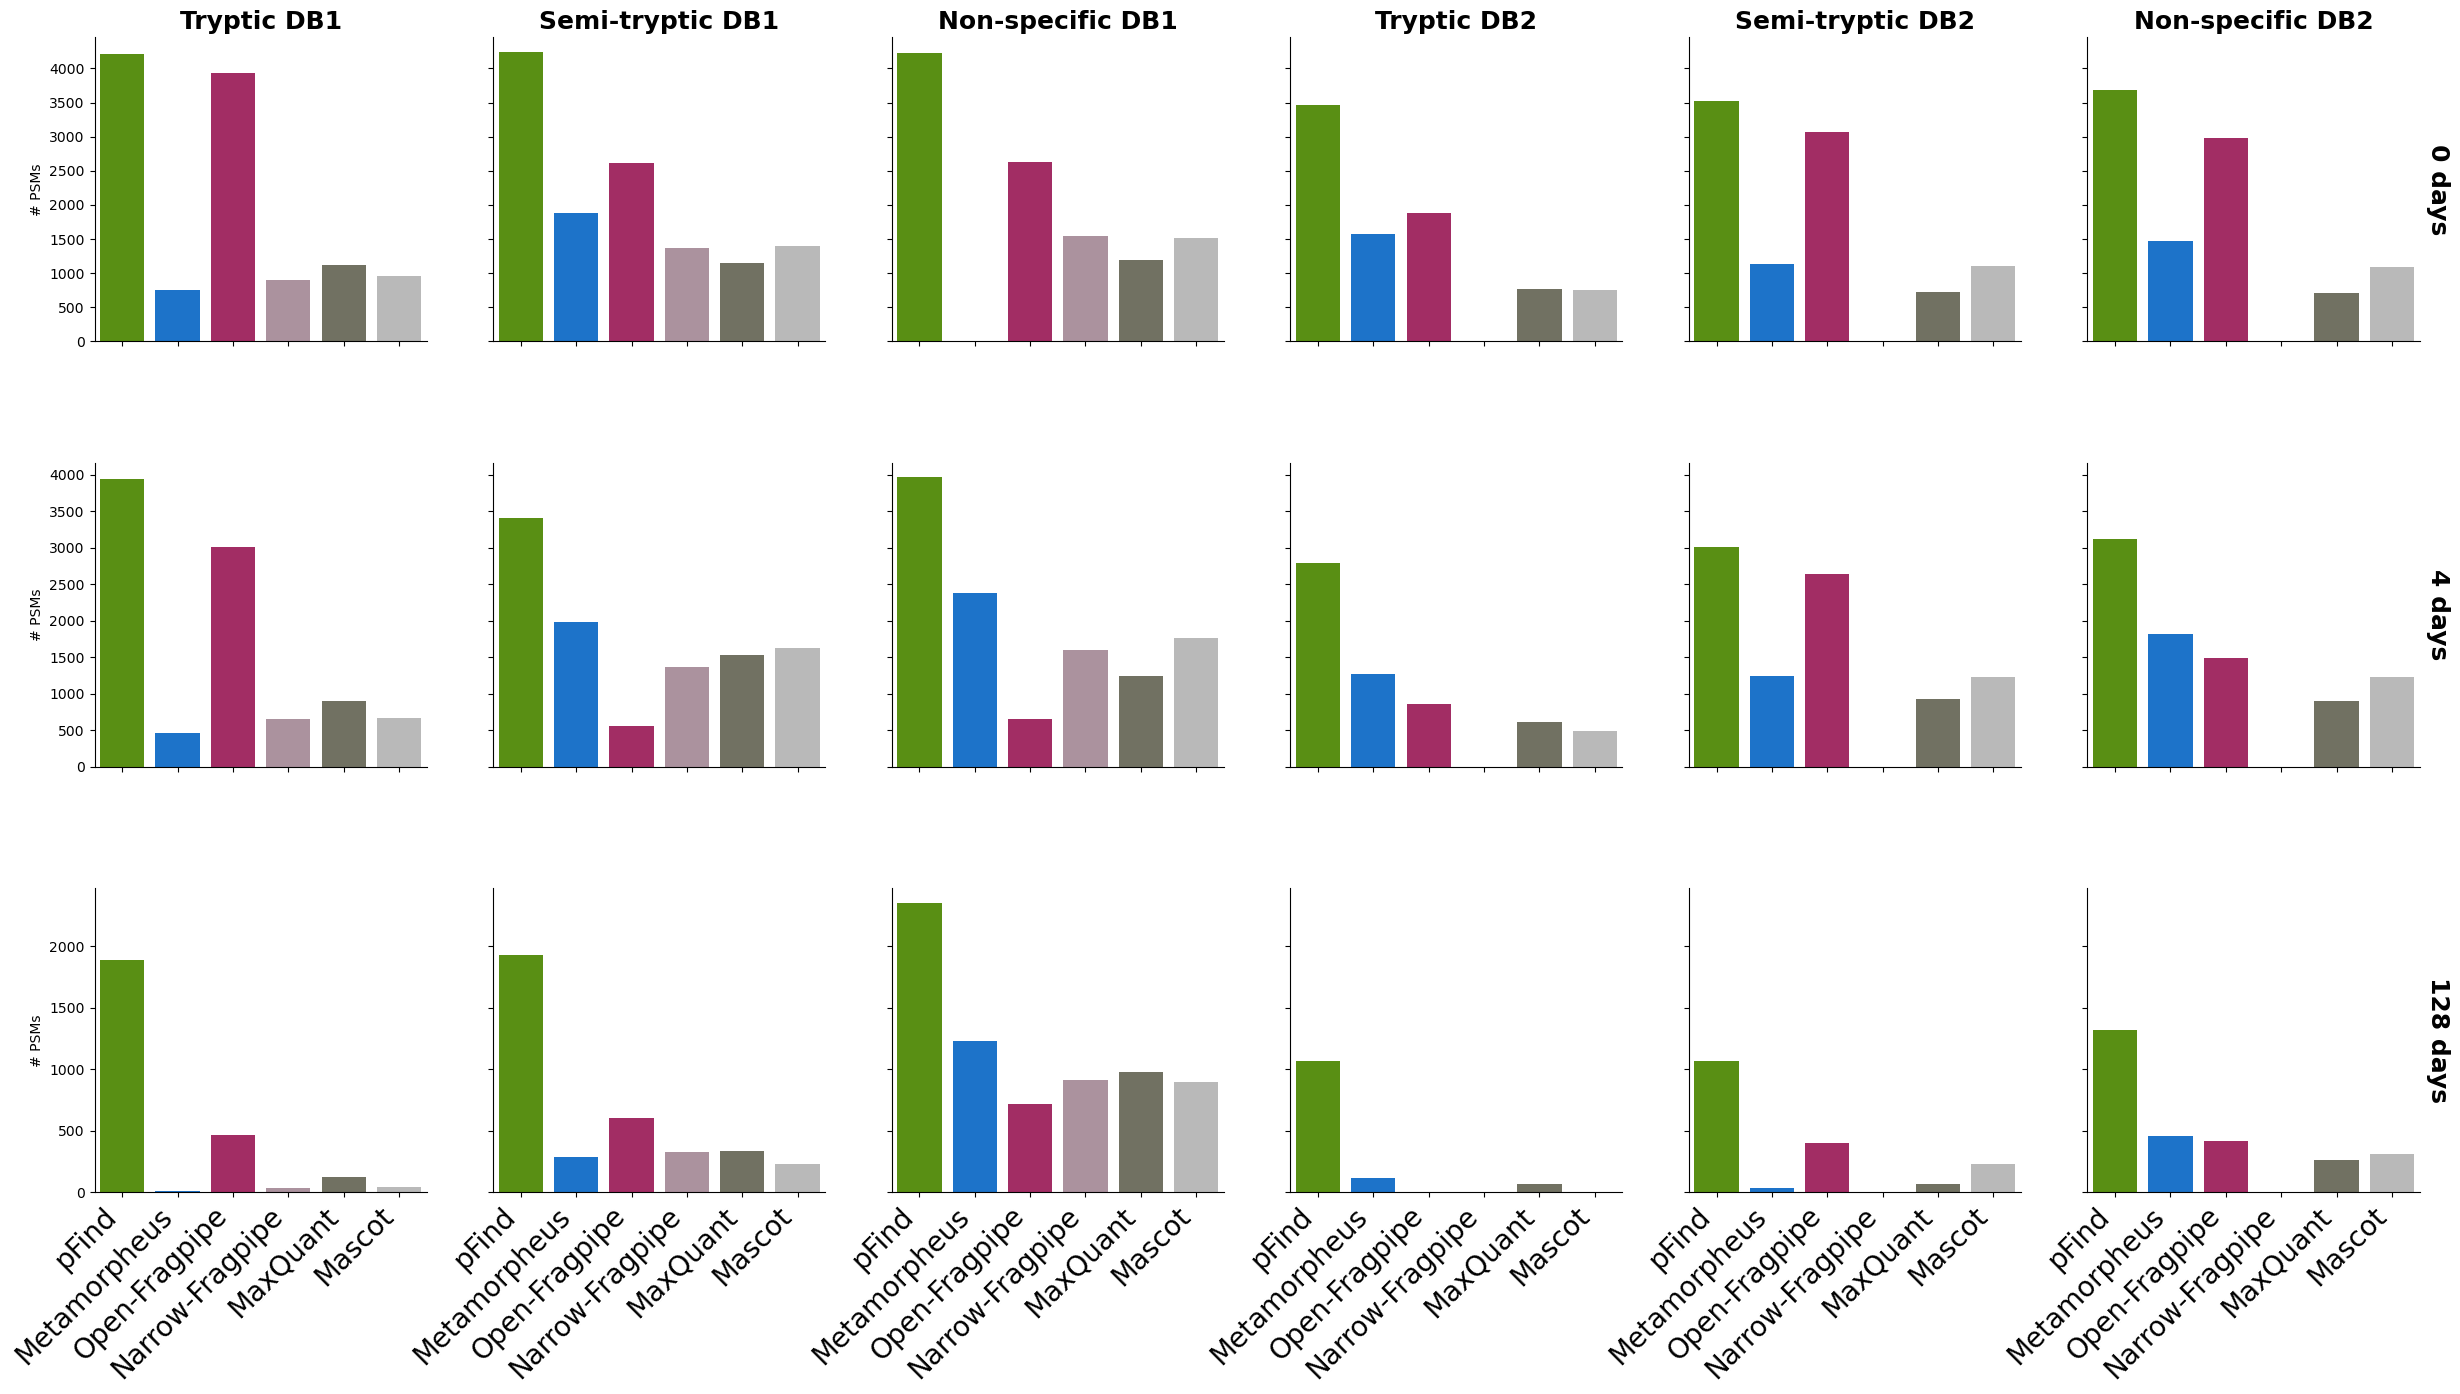

In [10]:
g1 = sns.catplot(
    psms_bar, x='Engine', y='n_psm', hue='Engine', row='Sample', col='Run settings', kind='bar',
    row_order = samples_colors.keys(), col_order = settings_linetype.keys(), sharey='row',
    palette=engine_shade, hue_order=list(engine_shade.keys()), order=list(engine_shade.keys()),
    margin_titles=True,
    facet_kws={'gridspec_kws': {"hspace":0.4}}
)
g1.set_titles(col_template="{col_name}", row_template="{row_name}", fontweight='bold', size=18)
for ax_row in g1.axes:
    for ax in ax_row:
        ax.set_xticks([0,1,2,3,4,5], list(engine_shade.keys()), fontsize=20,
                      rotation=45, ha='right')
        ax.set_xlabel('')
        ax.set_ylabel('# PSMs')
g1.figure.savefig(os.path.join(project, 'analysis_results', 'psms_counts', 'psms_report.png'), dpi=300)

In [11]:
benchmark_table

,Search,Engine,Digestion,DB,Pep_length,FDR,System,Run_id,Run settings,Run_extended,Run_settings
0,Open,Fragpipe,Tryptic,DB1,7-25,0.05,Cam HPC,fp_t_db1,Tryptic DB1,Fragpipe Tryptic DB1,Tryptic DB1
1,Open,Fragpipe,Tryptic,DB2,7-25,0.05,Cam HPC,fp_t_db2,Tryptic DB2,Fragpipe Tryptic DB2,Tryptic DB2
2,Open,Fragpipe,Semi-tryptic,DB1,7-25,0.05,Cam HPC,fp_st_db1,Semi-tryptic DB1,Fragpipe Semi-tryptic DB1,Semi-tryptic DB1
3,Open,Fragpipe,Semi-tryptic,DB1,5-25,0.05,Cam HPC,fp_st_5_db1,Semi-tryptic DB1,Fragpipe Semi-tryptic DB1,Semi-tryptic DB1
4,Open,Fragpipe,Semi-tryptic,DB2,7-25,0.05,Cam HPC,fp_st_db2,Semi-tryptic DB2,Fragpipe Semi-tryptic DB2,Semi-tryptic DB2
5,Open,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,fp_ns_db1,Non-specific DB1,Fragpipe Non-specific DB1,Non-specific DB1
6,Open,Fragpipe,Non-specific,DB2,7-25,0.05,Cam HPC,fp_ns_db2,Non-specific DB2,Fragpipe Non-specific DB2,Non-specific DB2
7,Closed,Fragpipe,Tryptic,DB1,7-25,0.05,Cam HPC,closed_fp_t_db1,Tryptic DB1,Fragpipe Tryptic DB1,Tryptic DB1
8,Closed,Fragpipe,Semi-tryptic,DB1,7-25,0.05,Cam HPC,closed_fp_st_db1,Semi-tryptic DB1,Fragpipe Semi-tryptic DB1,Semi-tryptic DB1
9,Closed,Fragpipe,Non-specific,DB1,7-25,0.05,Cam HPC,closed_fp_ns_db1,Non-specific DB1,Fragpipe Non-specific DB1,Non-specific DB1


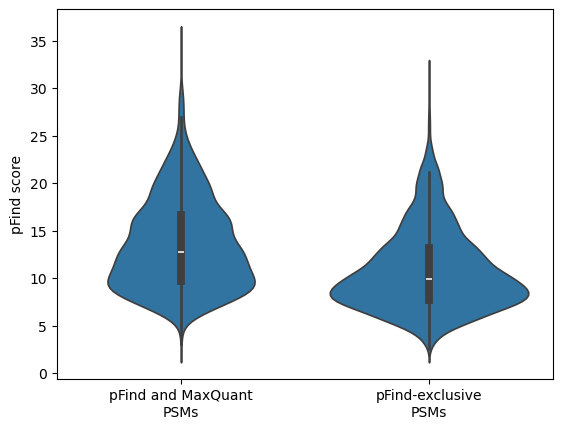

In [21]:
q_threshold = 0.05
runids = ['mq_ns_db1', 'pf_ns_db1']

psm_compare = psm_data_df.query('(Run_id in @runids) and q < @q_threshold and is_lacb == True').copy()

psm_pivot = psm_compare.pivot(index=['Scan_No', 'Sample'], columns='Run_id', values=['score', 'Seq'])

psm_pivot.columns = ['-'.join(col).strip() for col in psm_pivot.columns.values]
psm_pivot['match_id'] = psm_pivot[f'Seq-{runids[0]}'] == psm_pivot[f'Seq-{runids[1]}']
psm_pivot['pFind_exclusive'] = psm_pivot[f'score-mq_ns_db1'].isna()

fig, ax = plt.subplots()
ax = sns.violinplot(psm_pivot, x='pFind_exclusive', y='score-pf_ns_db1', ax=ax)
ax.set_ylabel('pFind score')
ax.set_xlabel(None)
ax.set_xticks([0, 1], ['pFind and MaxQuant\nPSMs', 'pFind-exclusive\nPSMs'])
fig.savefig(os.path.join(project, 'analysis_results/seq_comparisons', 'psms_compare.png'), dpi=300)

In [23]:
scores_exclusive = psm_pivot.loc[psm_pivot['pFind_exclusive'] == True, 'score-pf_ns_db1'].to_numpy().astype(float)
scores_common = psm_pivot.loc[psm_pivot['pFind_exclusive'] == False, 'score-pf_ns_db1'].to_numpy().astype(float)

In [24]:
from scipy.stats import ranksums
ranksums(scores_common, scores_exclusive, nan_policy='omit', alternative='greater')

RanksumsResult(statistic=29.475971598273755, pvalue=2.926011731702825e-191)

# Compare PSMs between open and closed search software

In [91]:
def blind_seq(seq):
    tr_dict = {
        'I': 'B',
        'L': 'B',
        'N': 'X',
        'D': 'X',
        'Q': 'Z',
        'E': 'Z'
    }
    seq = seq.translate(tr_dict)
    return seq



def compare_ids_distance(psm_data_df, runids, score_key, axes, q_threshold, metric='distance', log_scale=None):
    psm_compare = psm_data_df.query('(Run_id in @runids) and q < @q_threshold and is_lacb == True').copy()

    psm_pivot = psm_compare.pivot(index=['Scan_No', 'Sample'], columns='Run_id', values=[score_key, 'Seq', 'prot_id'])

    psm_pivot.columns = ['-'.join(col).strip() for col in psm_pivot.columns.values]
    psm_pivot['match_id'] = psm_pivot[f'Seq-{runids[0]}'] == psm_pivot[f'Seq-{runids[1]}']
    psm_pivot = psm_pivot.reset_index().dropna(how='any')
    
    perc_match = (
        psm_pivot
        .groupby('Sample')['match_id']
        .apply(lambda x: 100*x.sum()/len(x)).round(2)#.astype(str)
        .reset_index().iloc[manual_order,:])
    # annot_str = '\n'.join(perc_match['Sample'] + ' ' + perc_match['match_id'] + '%')
    # Calcualte Levenshtein rario
    if metric == 'distance':
        layer_threshold = 2
        psm_pivot[metric] = (
            psm_pivot[[f'Seq-{runids[0]}', f'Seq-{runids[1]}']]
            .apply(lambda x: Levenshtein.distance(x[f'Seq-{runids[0]}'], x[f'Seq-{runids[1]}'], processor=blind_seq), axis=1))
        # axes[0] = sns.histplot(
        #     psm_pivot, x=metric, hue='Sample', hue_order=samples,
        #     stat='density', discrete=True, multiple='stack', element='bars',
        #     ax=axes[0], alpha=1, shrink=1, common_norm=False, palette=samples_colors)
        # axes[0].annotate(annot_str, xy=(0.4, 0.7), xycoords='axes fraction', fontsize=12)
    elif metric == 'ratio':
        layer_threshold = 0.9
        psm_pivot[metric] = (
            psm_pivot[[f'Seq-{runids[0]}', f'Seq-{runids[1]}']]
            .apply(lambda x: Levenshtein.ratio(x[f'Seq-{runids[0]}'], x[f'Seq-{runids[1]}'], processor=blind_seq), axis=1))
        # axes[0] = sns.histplot(
        #     psm_pivot, x=metric, hue='Sample', hue_order=samples,
        #     stat='density', bins=15, multiple='stack', element='bars',
        #     ax=axes[0], alpha=1, shrink=1, common_norm=False, palette=samples_colors)
        # axes[0].annotate(annot_str, xy=(0.75, 0.8), xycoords='axes fraction', fontsize=12)
    else:
        sys.exit('Only implemented metrics are distance and ratio')
    axes[0] = sns.barplot(perc_match, x='Sample', y='match_id', ax=axes[0], hue='Sample', palette=samples_greyscale)
    axes[0].set_ylim(50,95)
    handles = []    
    cm_vmin = 0
    cm_vmax = 15
    for l in [0, 1]:
        layer_size = (l + 1) * 30
        layer_alpha = (l + 1) * 0.5 
        if metric == 'distance' and l == 0:
            layer_data = psm_pivot[psm_pivot[metric] < layer_threshold]
        elif metric == 'distance' and l == 1:
            layer_data = psm_pivot[psm_pivot[metric] >= layer_threshold]
        elif metric == 'ratio' and l == 0:
            layer_data = psm_pivot[psm_pivot[metric] >= layer_threshold]
        elif metric == 'ratio' and l == 1:
            layer_data = psm_pivot[psm_pivot[metric] < layer_threshold]
        for sam in samples:
            sample_data = layer_data[layer_data['Sample'] == sam]
            axes[1].scatter(
                data=sample_data, x=f'{score_key}-{runids[0]}', y=f'{score_key}-{runids[1]}', c='distance',
                cmap='viridis_r', vmin=cm_vmin, vmax=cm_vmax,
                marker=samples_markers[sam], s=layer_size, alpha=layer_alpha, label=sam, edgecolors='black')
            handles.append(plt.scatter([],[], color='black', marker=samples_markers[sam], label=sam))
    plt.close()
    axes[1].legend(handles, samples, loc='upper right')

    norm = mcolors.Normalize(vmin=cm_vmin, vmax=cm_vmax)
    sm = cm.ScalarMappable(cmap='viridis_r', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='distance', ax=axes[1], location='right', orientation='vertical', shrink=0.5)
    # fig.tight_layout()
    if log_scale == 'y':
        axes[1].set_yscale('log')
    elif log_scale == 'x':
        axes[1].set_xscale('log')
    elif log_scale == 'both':
        axes[1].set_yscale('log')
        axes[1].set_xscale('log')

### MaxQuant vs Fragpipe

In [ ]:
fig1, axes1 = plt.subplots(
    nrows=3, ncols=2, sharex='col', figsize=(12,9), layout='constrained')
db_setting = 'db1'
compare_ids_distance(psm_data_df, runids=[f'fp_t_{db_setting}', f'mq_t_{db_setting}'], score_key='score', axes=axes1[0,:], q_threshold=0.05, log_scale=None)
axes1[0,0].set_title('Tryptic search with DB1', fontsize=12, loc='right')
axes1[0,0].set_xlabel('Peptide similarity ratio')
axes1[0,1].set_xlabel('Fragpipe Hypersocre')
axes1[0,1].set_ylabel('Andromeda Score')

compare_ids_distance(psm_data_df, runids=[f'fp_st_{db_setting}', f'mq_st_{db_setting}'], score_key='score', axes=axes1[1,:], q_threshold=0.05, log_scale=None)
axes1[1,0].set_title('Semi-tryptic search with DB1', fontsize=12, loc='right')
axes1[1,0].set_xlabel('Peptide similarity ratio')
axes1[1,1].set_xlabel('Fragpipe Hyperscore')
axes1[1,1].set_ylabel('Andromeda Score')

compare_ids_distance(psm_data_df, runids=[f'fp_ns_{db_setting}', f'mq_ns_{db_setting}'], score_key='score', axes=axes1[2,:], q_threshold=0.05, log_scale=None)
axes1[2,0].set_title('Non-specific search with DB1', fontsize=12, loc='right')
axes1[2,0].set_xlabel('Peptide similarity ratio')
axes1[2,1].set_xlabel('Fragpipe Hyperscore')
axes1[2,1].set_ylabel('Andromeda Score')

fig1.suptitle('MaxQuant vs Fragpipe')
fig1.savefig(os.path.join(project, 'analysis_results', 'seq_comparisons', 'dist_mq_vs_fp_db1.png'), bbox_inches='tight')
fig1

### MaxQuant vs pFind

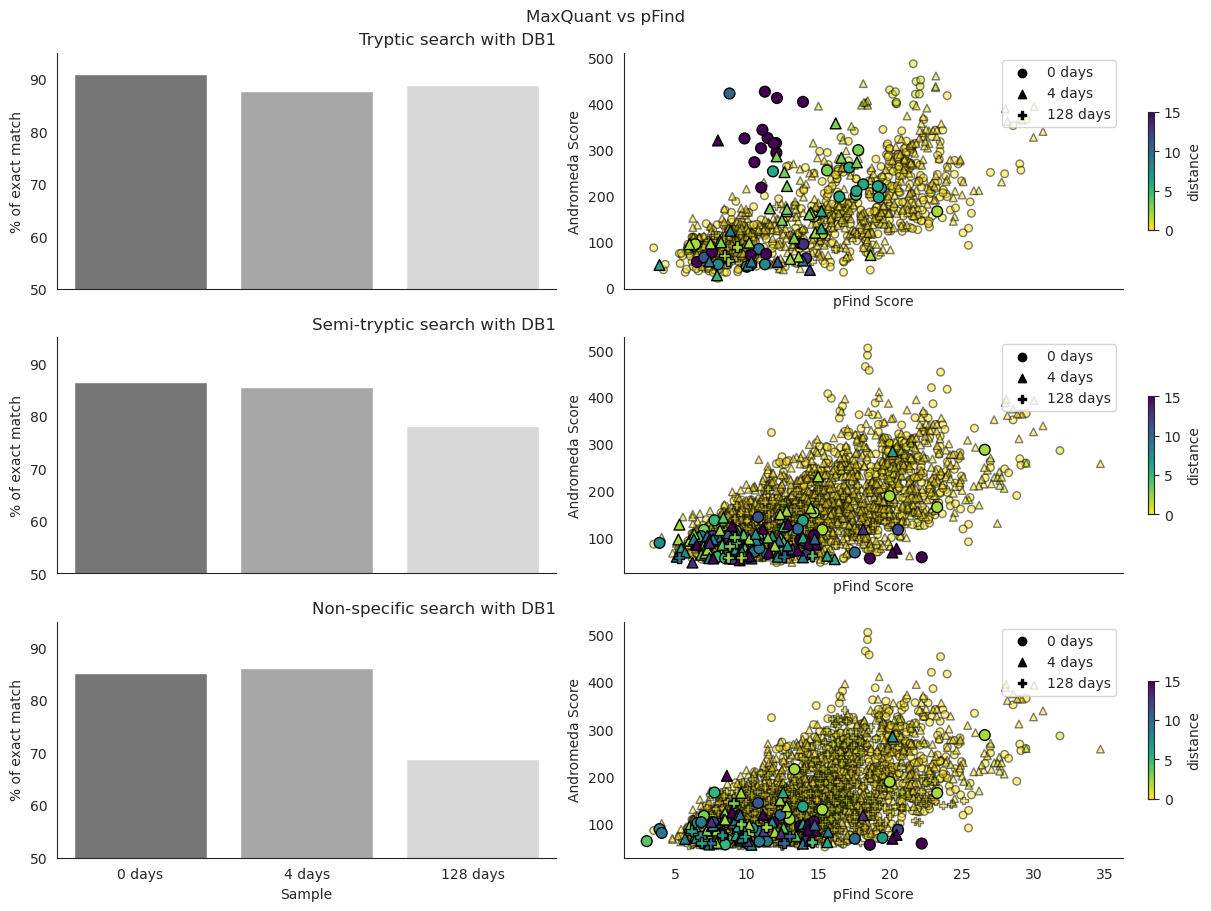

<Figure size 640x480 with 0 Axes>

In [94]:
with sns.axes_style("white"):
    fig1, axes1 = plt.subplots(
        nrows=3, ncols=2, sharex='col', figsize=(12,9), layout='constrained')
    db_setting = 'db1'
    compare_ids_distance(psm_data_df, runids=[f'pf_t_{db_setting}', f'mq_t_{db_setting}'], score_key='score', axes=axes1[0,:], q_threshold=0.05, log_scale=None)
    axes1[0,0].set_title('Tryptic search with DB1', fontsize=12, loc='right')
    axes1[0,0].set_xlabel('Sample')
    axes1[0,0].set_ylabel('% of exact match')
    axes1[0,1].set_xlabel('pFind Score')
    axes1[0,1].set_ylabel('Andromeda Score')
    
    compare_ids_distance(psm_data_df, runids=[f'pf_st_{db_setting}', f'mq_st_{db_setting}'], score_key='score', axes=axes1[1,:], q_threshold=0.05, log_scale=None)
    axes1[1,0].set_title('Semi-tryptic search with DB1', fontsize=12, loc='right')
    axes1[1,0].set_xlabel('Sample')
    axes1[1,0].set_ylabel('% of exact match')
    axes1[1,1].set_xlabel('pFind Score')
    axes1[1,1].set_ylabel('Andromeda Score')
    
    compare_ids_distance(psm_data_df, runids=[f'pf_ns_{db_setting}', f'mq_ns_{db_setting}'], score_key='score', axes=axes1[2,:], q_threshold=0.05, log_scale=None)
    axes1[2,0].set_title('Non-specific search with DB1', fontsize=12, loc='right')
    axes1[2,0].set_xlabel('Sample')
    axes1[2,0].set_ylabel('% of exact match')
    axes1[2,1].set_xlabel('pFind Score')
    axes1[2,1].set_ylabel('Andromeda Score')
    fig1.suptitle('MaxQuant vs pFind')
    sns.despine(fig1)
    fig1.savefig(os.path.join(project, 'analysis_results', 'seq_comparisons', 'dist_mq_vs_pf_db1.png'), bbox_inches='tight')
    fig1.savefig(os.path.join(project, 'analysis_results', 'seq_comparisons', 'dist_mq_vs_pf_db1.svg'), bbox_inches='tight')
fig1

### MaxQuant vs Mascot

In [ ]:
fig1, axes1 = plt.subplots(
    nrows=3, ncols=2, sharex='col', figsize=(12,9), layout='constrained')
db_setting = 'db1'
compare_ids_distance(psm_data_df, runids=[f'mascot_t_{db_setting}', f'mq_t_{db_setting}'], score_key='score', axes=axes1[0,:], q_threshold=0.05, log_scale=None)
axes1[0,0].set_title('Tryptic search with DB1', fontsize=12, loc='right')
axes1[0,0].set_xlabel('Peptide similarity ratio')
axes1[0,1].set_xlabel('Mascot Score')
axes1[0,1].set_ylabel('Andromeda Score')

compare_ids_distance(psm_data_df, runids=[f'mascot_st_{db_setting}', f'mq_st_{db_setting}'], score_key='score', axes=axes1[1,:], q_threshold=0.05, log_scale=None)
axes1[1,0].set_title('Semi-tryptic search with DB1', fontsize=12, loc='right')
axes1[1,0].set_xlabel('Peptide similarity ratio')
axes1[1,1].set_xlabel('Mascot Score')
axes1[1,1].set_ylabel('Andromeda Score')

compare_ids_distance(psm_data_df, runids=[f'mascot_ns_{db_setting}', f'mq_ns_{db_setting}'], score_key='score', axes=axes1[2,:], q_threshold=0.05, log_scale=None)
axes1[2,0].set_title('Non-specific search with DB1', fontsize=12, loc='right')
axes1[2,0].set_xlabel('Peptide similarity ratio')
axes1[2,1].set_xlabel('Mascot Score')
axes1[2,1].set_ylabel('Andromeda Score')
fig1.suptitle('MaxQuant vs Mascot')
fig1.savefig(os.path.join(project, 'analysis_results', 'seq_comparisons', 'dist_mq_vs_mascot_db1.png'), bbox_inches='tight')
fig1

### pFind vs Fragpipe

In [ ]:
fig1, axes1 = plt.subplots(
    nrows=3, ncols=2, sharex='col', figsize=(12,9), layout='constrained')
db_setting = 'db1'
compare_ids_distance(psm_data_df, runids=[f'fp_t_{db_setting}', f'pf_t_{db_setting}'], score_key='score', axes=axes1[0,:], q_threshold=0.05, log_scale=None)
axes1[0,0].set_title('Tryptic search with DB1', fontsize=12, loc='right')
axes1[0,0].set_xlabel('Peptide similarity ratio')
axes1[0,1].set_xlabel('Fragpipe Hyperscore')
axes1[0,1].set_ylabel('pFind Score')

compare_ids_distance(psm_data_df, runids=[f'fp_st_{db_setting}', f'pf_st_{db_setting}'], score_key='score', axes=axes1[1,:], q_threshold=0.05, log_scale=None)
axes1[1,0].set_title('Semi-tryptic search with DB1', fontsize=12, loc='right')
axes1[1,0].set_xlabel('Peptide similarity ratio')
axes1[1,1].set_xlabel('Fragpipe Hyperscore')
axes1[1,1].set_ylabel('pFind Score')

compare_ids_distance(psm_data_df, runids=[f'fp_ns_{db_setting}', f'pf_ns_{db_setting}'], score_key='score', axes=axes1[2,:], q_threshold=0.05, log_scale=None)
axes1[2,0].set_title('Non-specific search with DB1', fontsize=12, loc='right')
axes1[2,0].set_xlabel('Peptide similarity ratio')
axes1[2,1].set_xlabel('Fragpipe Hyperscore')
axes1[2,1].set_ylabel('pFind Score')
fig1.suptitle('Fragpipe vs pFind')
fig1.savefig(os.path.join(project, 'analysis_results', 'seq_comparisons', 'dist_pf_vs_fp_db1.png'), bbox_inches='tight')
fig1

# UpSet plots on PSMs

In [33]:
psm_data_df['Run_extended'] = psm_data_df['Engine'] + ' ' + psm_data_df['Digestion'] + ' ' + psm_data_df['DB']
def compare_seqs(scan, upset_test, sample):
    seqs = upset_test.loc[(upset_test['Sample'] == sample) & (upset_test['Scan_No'] == int(scan)), 'Seq']
    if len(seqs) == 1:
        mean_ratio = 0
    else:
        mean_ratio = np.mean([Levenshtein.distance(s1, s2, processor=blind_seq) for s1, s2 in pairwise(seqs)])
    # alleq = len(set(seqs)) == 1
    # return alleq
    return 'consensus' if mean_ratio <= 1 else 'disputed'



In [34]:

def make_upset(db, engines, sample, comp, bm_table, by='Scan_No'):
    upset_test = (
        psm_data_df
        .query('DB == @db and Engine in @engines and Sample == @sample and q < 0.05 and is_lacb == True')
        .copy())
    
    runid_groups = upset_test[['Run_extended', by]].groupby('Run_extended')
    
    contents = {}
    for runid in runid_groups.indices.keys():
        runid_psms = runid_groups.get_group(runid)[by]
        # runid_psms = runid_psms['Sample'].str.cat(runid_psms['Scan_No'].astype(str), sep='-')
        contents[runid] = set(runid_psms.tolist())

    contents = from_contents(contents)
    if by == 'Scan_No':
        contents['same_pep'] = contents['id'].apply(compare_seqs, upset_test=upset_test, sample=sample)
        
        upset_obj = UpSet(contents, subset_size="count", min_subset_size='1%', max_subset_size='70%',
                          show_percentages=True, sort_categories_by='input', sort_by='cardinality',
                          intersection_plot_elements=0, shading_color=0.1)
        upset_obj.add_stacked_bars(by='same_pep', colors=['#5ba300', '#b51963'], title='Counts by\nPeptide Identity')
    elif by == 'Seq':
        upset_obj = UpSet(contents, subset_size="count", min_subset_size='1%', max_subset_size='70%',
                          show_percentages=True, sort_categories_by='input', sort_by='cardinality',
                          shading_color=0.1)
    for elements in bm_table.itertuples(index=False):
        run_id_ext = elements[0]
        settings = elements[1]
        engine = elements[2]
        if run_id_ext not in contents.index.names:
            continue
        upset_obj.style_categories(
            run_id_ext, shading_edgecolor=engine_shade[engine],
            shading_linestyle=settings_linetype[settings], shading_linewidth=2,
            shading_facecolor='white'
        )
    ax_dict = upset_obj.plot()
    plt.savefig(os.path.join(project, 'analysis_results', 'upset_psm', f'{comp}_{by}_{sample}_db1.png'))


### Open search software

In [35]:

engines = ['pFind', 'Fragpipe', 'Metamorpheus']
open_benchmark = benchmark_table.loc[benchmark_table['Search'] == 'Open', ['Run_extended', 'Run_settings', 'Engine']]

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

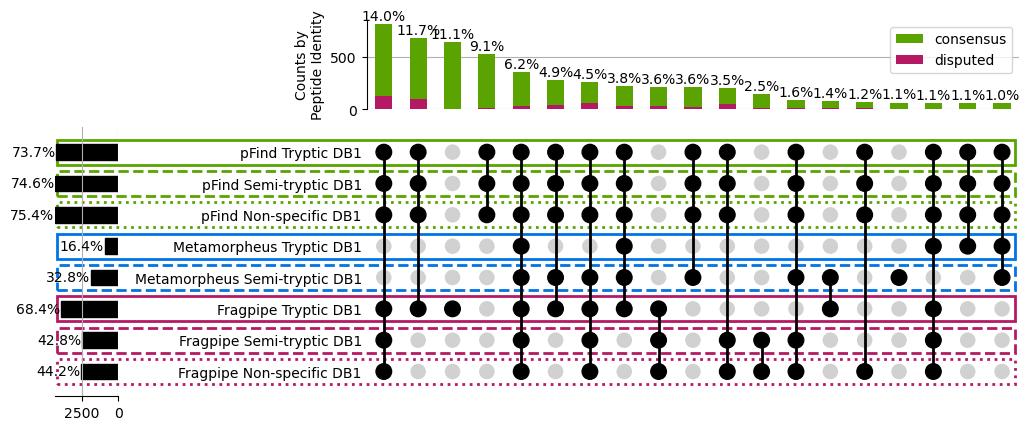

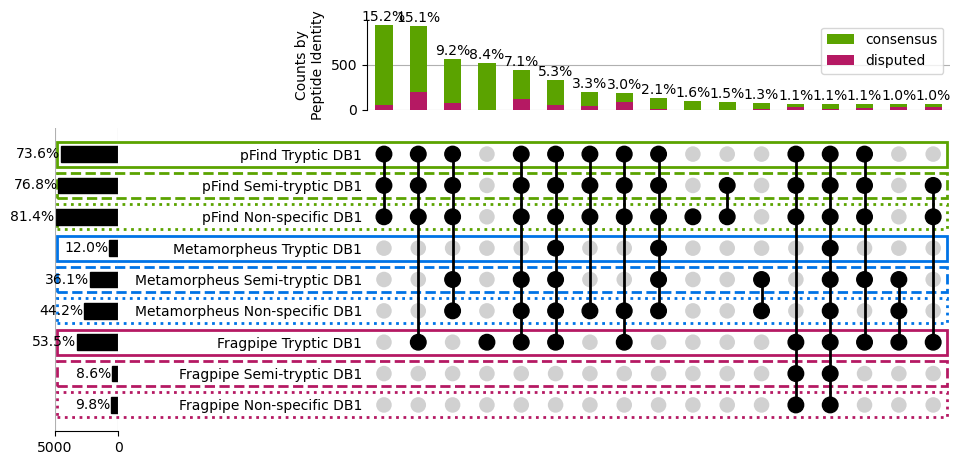

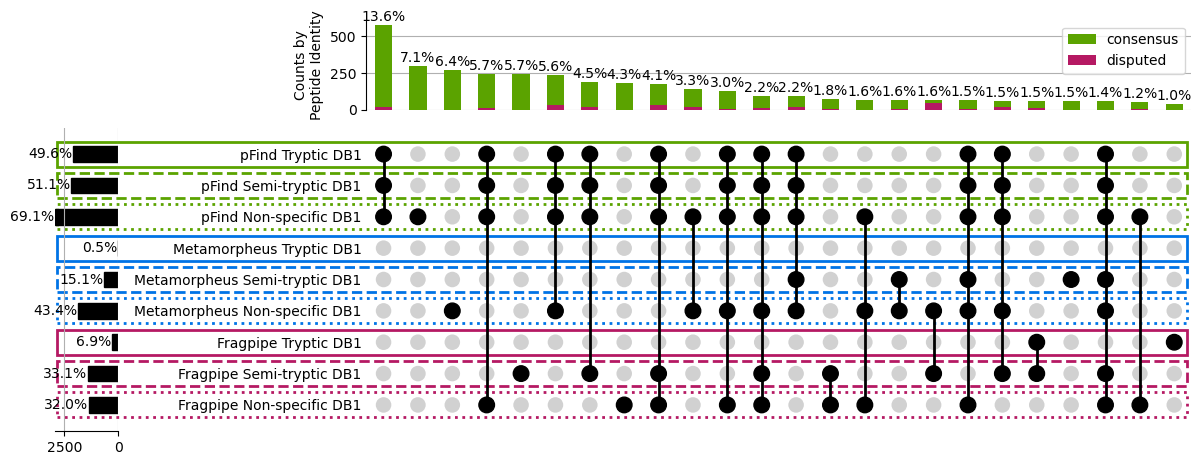

In [36]:
make_upset('DB1', engines, '0 days', comp='open', bm_table=open_benchmark)
make_upset('DB1', engines, '4 days', comp='open', bm_table=open_benchmark)
make_upset('DB1', engines, '128 days', comp='open', bm_table=open_benchmark)

### 1 open vs 1 closed

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

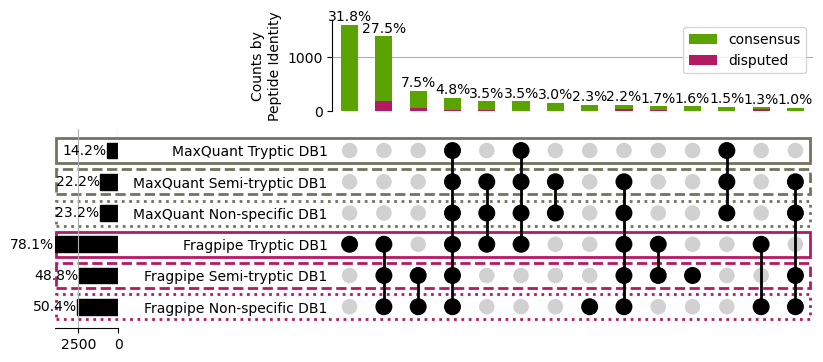

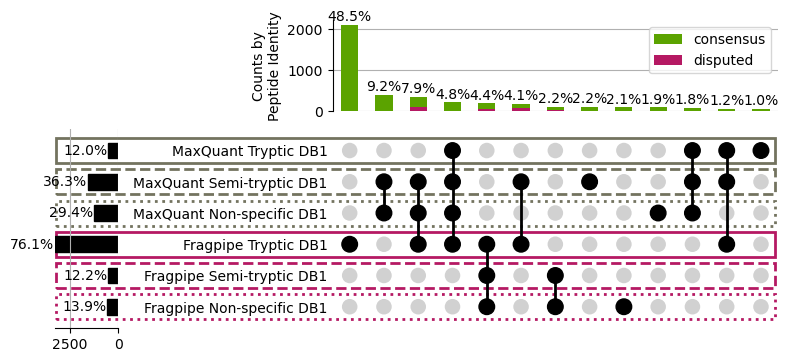

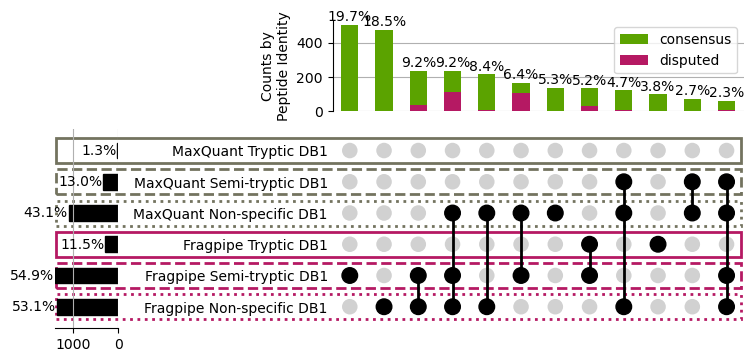

In [37]:
engines = ['Fragpipe', 'MaxQuant']
open_vs_closed = benchmark_table.loc[benchmark_table['Engine'].isin(engines), ['Run_extended', 'Run_settings', 'Engine']]

make_upset('DB1', engines, '0 days', comp='fp_vs_mq', bm_table=open_vs_closed)
make_upset('DB1', engines, '4 days', comp='fp_vs_mq', bm_table=open_vs_closed)
make_upset('DB1', engines, '128 days', comp='fp_vs_mq', bm_table=open_vs_closed)

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

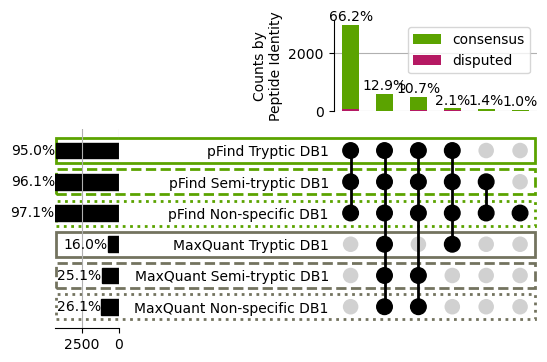

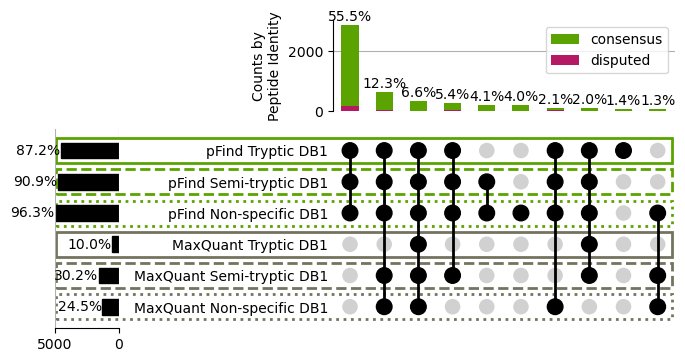

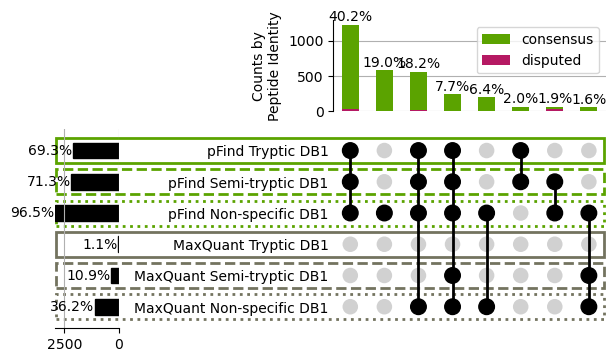

In [38]:
engines = ['pFind', 'MaxQuant']
open_vs_closed = benchmark_table.loc[benchmark_table['Engine'].isin(engines), ['Run_extended', 'Run_settings', 'Engine']]

make_upset('DB1', engines, '0 days', comp='pf_vs_mq', bm_table=open_vs_closed)
make_upset('DB1', engines, '4 days', comp='pf_vs_mq', bm_table=open_vs_closed)
make_upset('DB1', engines, '128 days', comp='pf_vs_mq', bm_table=open_vs_closed)


# UpSet plots on distinct peptides

### Compare Open Search

In [21]:
engines = ['pFind', 'Fragpipe', 'Metamorpheus']

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

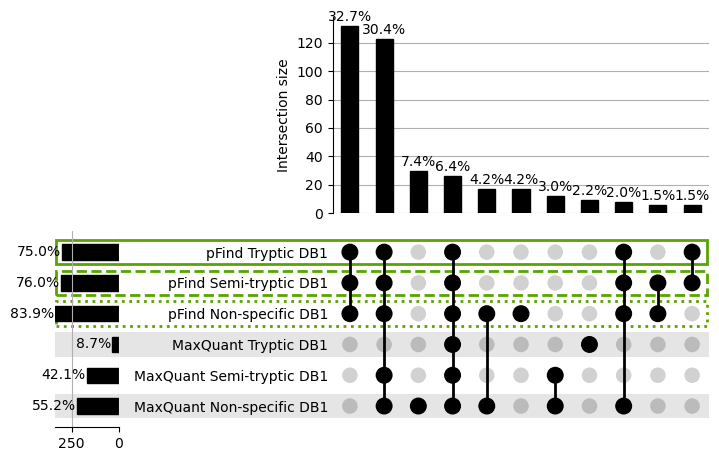

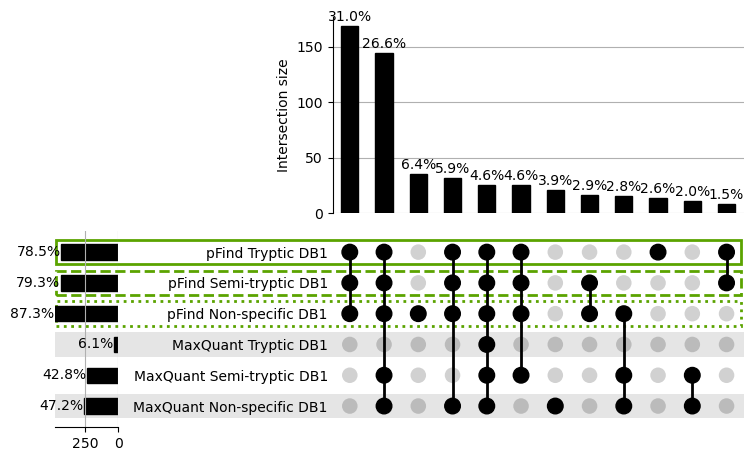

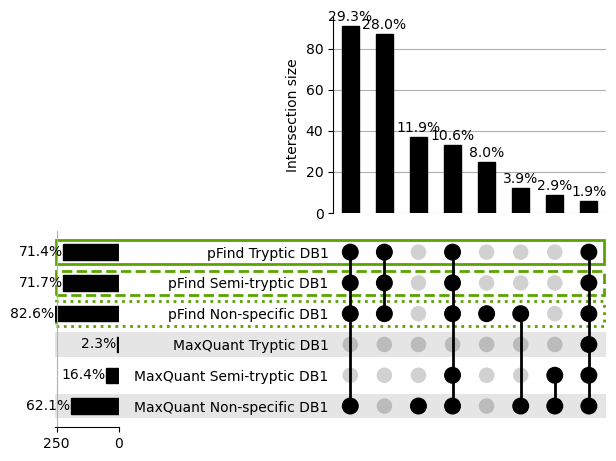

In [37]:

make_upset('DB1', engines, '0 days', comp='open', bm_table=open_benchmark, by='Seq')
make_upset('DB1', engines, '4 days', comp='open', bm_table=open_benchmark, by='Seq')
make_upset('DB1', engines, '128 days', comp='open', bm_table=open_benchmark, by='Seq')

## 1 open vs 1 closed

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

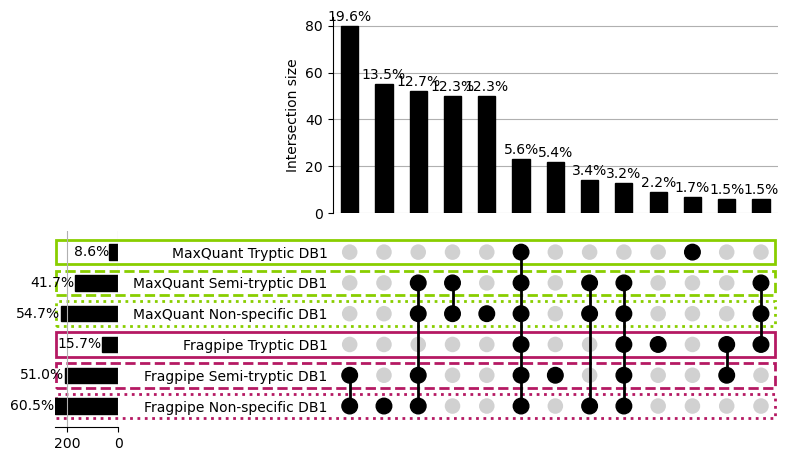

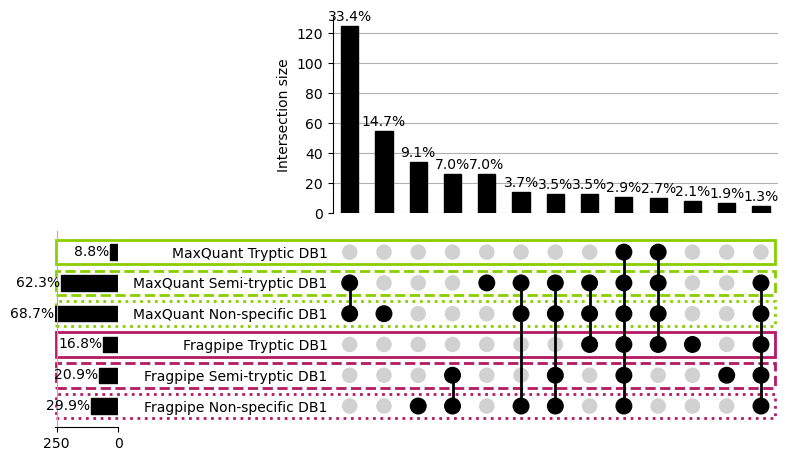

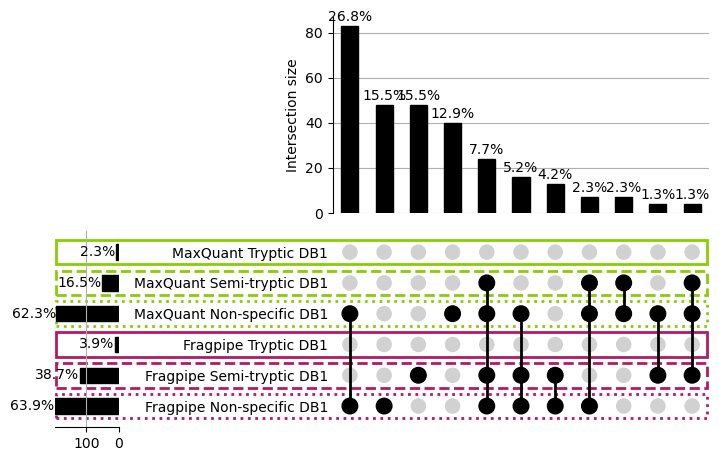

In [38]:
engines = ['Fragpipe', 'MaxQuant']
open_vs_closed = benchmark_table.loc[benchmark_table['Engine'].isin(engines), ['Run_extended', 'Run_settings', 'Engine']]

make_upset('DB1', engines, '0 days', comp='fp_vs_mq', bm_table=open_vs_closed, by='Seq')
make_upset('DB1', engines, '4 days', comp='fp_vs_mq', bm_table=open_vs_closed, by='Seq')
make_upset('DB1', engines, '128 days', comp='fp_vs_mq', bm_table=open_vs_closed, by='Seq')

/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/ismael/anaconda3/envs/palaeopsm/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

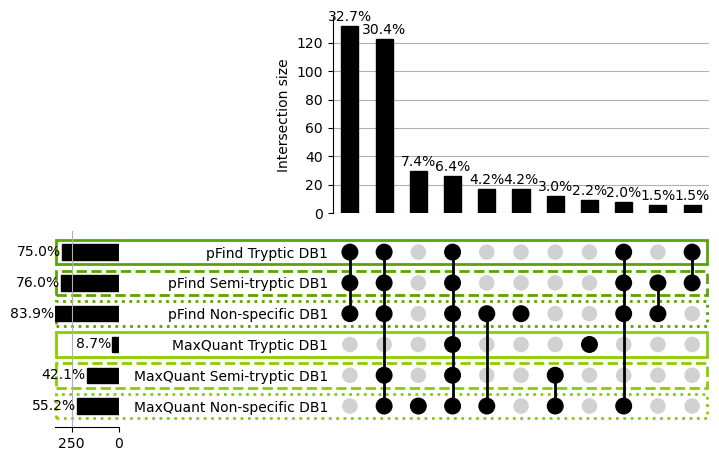

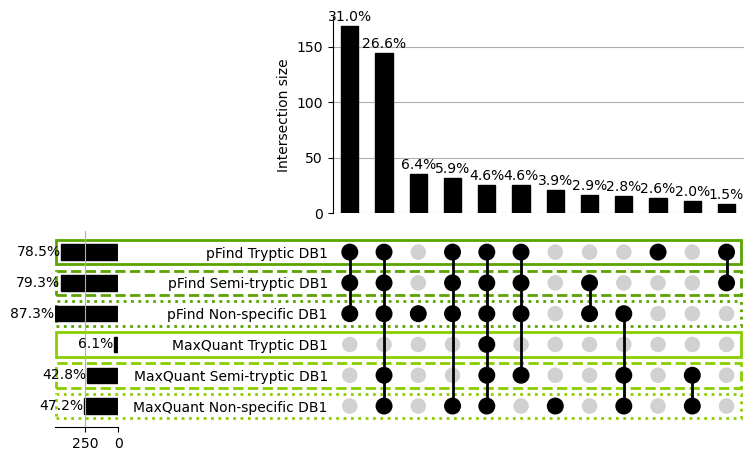

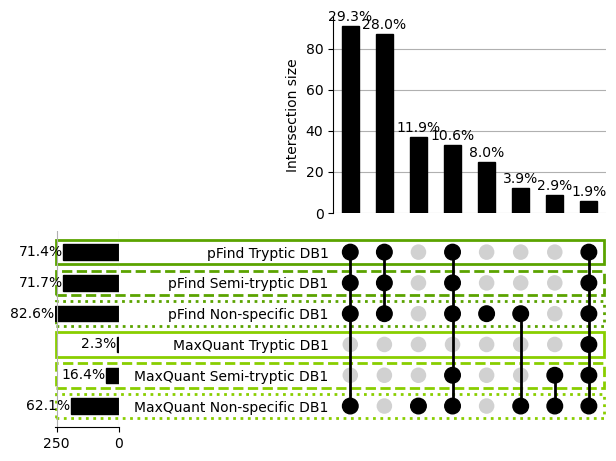

In [39]:
engines = ['pFind', 'MaxQuant']
open_vs_closed = benchmark_table.loc[benchmark_table['Engine'].isin(engines), ['Run_extended', 'Run_settings', 'Engine']]

make_upset('DB1', engines, '0 days', comp='pf_vs_mq', bm_table=open_vs_closed, by='Seq')
make_upset('DB1', engines, '4 days', comp='pf_vs_mq', bm_table=open_vs_closed, by='Seq')
make_upset('DB1', engines, '128 days', comp='pf_vs_mq', bm_table=open_vs_closed, by='Seq')

# Peptide properties

### Isoelectric point and GRAVY

Here we calculate the isoelectric point and GRAVY using a sliding window along the BLG sequence (P02754).

This is just to compare with pI calculated on the peptides identified by MS.

In [22]:
# Use one of the MaxQuant runs to extract the peptides with pI and GRAVY
pos_counts_test = (
    position_counts
    .query('Run_id == "mq_st_db1" and Sample == "N0040" and is_lacb == True and gt_005fdr == False')
    .copy())
pos_counts_test['mean_pI_ma'] = pos_counts_test['mean_pI'].rolling(6).mean()


# Calculate pI on a rolling window on the BLG sequence
start = 17 - 1
start = 1
halfwindow_size = 7
blg_str = str(blga_seq[0].seq)
pI_data = []
for i in range(start + halfwindow_size, len(blg_str) - halfwindow_size + 1):
    pep = blg_str[i-halfwindow_size: i+halfwindow_size]
    aa = blg_str[i]
    pI_data.append([i, aa, pep, electrochem.pI(pep, precision_pI=0.01), electrochem.gravy(pep)])
pI_data = pd.DataFrame(pI_data, columns=['position', 'aminoacid', 'peptide', 'pI', 'gravy'])
pI_data['mean_pI'] = pI_data['pI'].rolling(3).mean()
pI_data['mean_gravy'] = pI_data['gravy'].rolling(3).mean()

### Relative accessible surface area

I have collected the DSSP results on the BLG PDB entry 7KOT. These include the absolete ASA in $\mathring{A}^2$. I calculated the relative exposure by dividing by the theoretical maximum solvent exposure values from Tien at al. (2013).

In [24]:
dssp_file = os.path.join(project, 'bovin_blg', 'dssp_properties', '7kot_dssp.txt')

header = True
data_asa = []
with open(dssp_file, 'r') as dssp_in:
    for line in dssp_in:
        if line[2] != "#" and header is True:
            continue
        elif line[2] == "#" and header is True:
            header = False
            continue
        elif line[2] != "#" and header is False:
            residue = line[13]
            if residue == '!':
                continue
            asa = int(line[35:38].strip())
            position = int(line[7:10].strip()) + 16 - 1
            data_asa.append([residue, position, asa])
data_asa = pd.DataFrame(data_asa, columns = ['pep_letters', 'pep_positions', 'asa'])

max_asa_file = os.path.join(project, 'bovin_blg', 'dssp_properties', 'max_asa_tien.csv')
max_asa = pd.read_csv(max_asa_file)
# Merge them
data_asa = data_asa.merge(max_asa, 'left', on='pep_letters')
data_asa['r_asa'] = data_asa['asa']/data_asa['th_max_asa']
data_asa['r_asa_mean'] = data_asa['r_asa'].rolling(3).mean()

# Get R and K positions from RASA dataframe and plot vertical lines to display tryptic sites
asa_tryptic = data_asa.loc[data_asa['pep_letters'].isin(['R', 'K']), 'pep_positions']

### B-factors and flexibility

In [6]:
parser = PDBParser()
structure = parser.get_structure("BLG", os.path.join(project, 'bovin_blg', '7kot.pdb'))

In [29]:
i = 17
b_factor = []
for r in structure.get_residues():
    if r.get_resname() in ['SDS', 'HOH']:
        continue
    for a in r.get_atoms():
        if a.get_name() in ['CA', 'C', 'N']:
            aa_part = 'backbone'
        else:
            aa_part = 'side chain'
        b_factor.append([i, r.get_resname(), a.get_name(), aa_part, a.get_bfactor()])
    i += 1
b_factor = pd.DataFrame(
    b_factor,
    columns=['position', 'res_name', 'atom', 'aminoacid_part', 'B-factor']
)
b_factor

,position,res_name,atom,aminoacid_part,B-factor
0,17,ILE,N,backbone,59.70
1,17,ILE,CA,backbone,54.54
2,17,ILE,C,backbone,48.02
3,17,ILE,O,side chain,54.91
4,17,ILE,CB,side chain,59.84
...,...,...,...,...,...
1216,173,ILE,CB,side chain,43.63
1217,173,ILE,CG1,side chain,45.69
1218,173,ILE,CG2,side chain,51.18
1219,173,ILE,CD1,side chain,44.52


### Amyloid propensity position-wise

In [25]:
anupp = pd.read_csv(os.path.join(project, 'bovin_blg', 'amyloid_propensity', 'ANuPP_rawpred.csv'))
appnn = pd.read_csv(os.path.join(project, 'bovin_blg', 'amyloid_propensity', 'appnn_amylopred.csv'))
anupp['position'] = anupp['Segment No.'] + 2

amylogram = pd.read_csv(os.path.join(project, 'bovin_blg', 'amyloid_propensity', 'AmyloGram.csv'))


In [ ]:
pI_data['position'].isin(asa_tryptic)
anupp

In [ ]:
print(anupp.columns)
print(appnn.columns)
print(amylogram.columns)

### Plotting properties

- B_factors
- GRAVY
- RSA
- Amyoloid prpensity
- pI

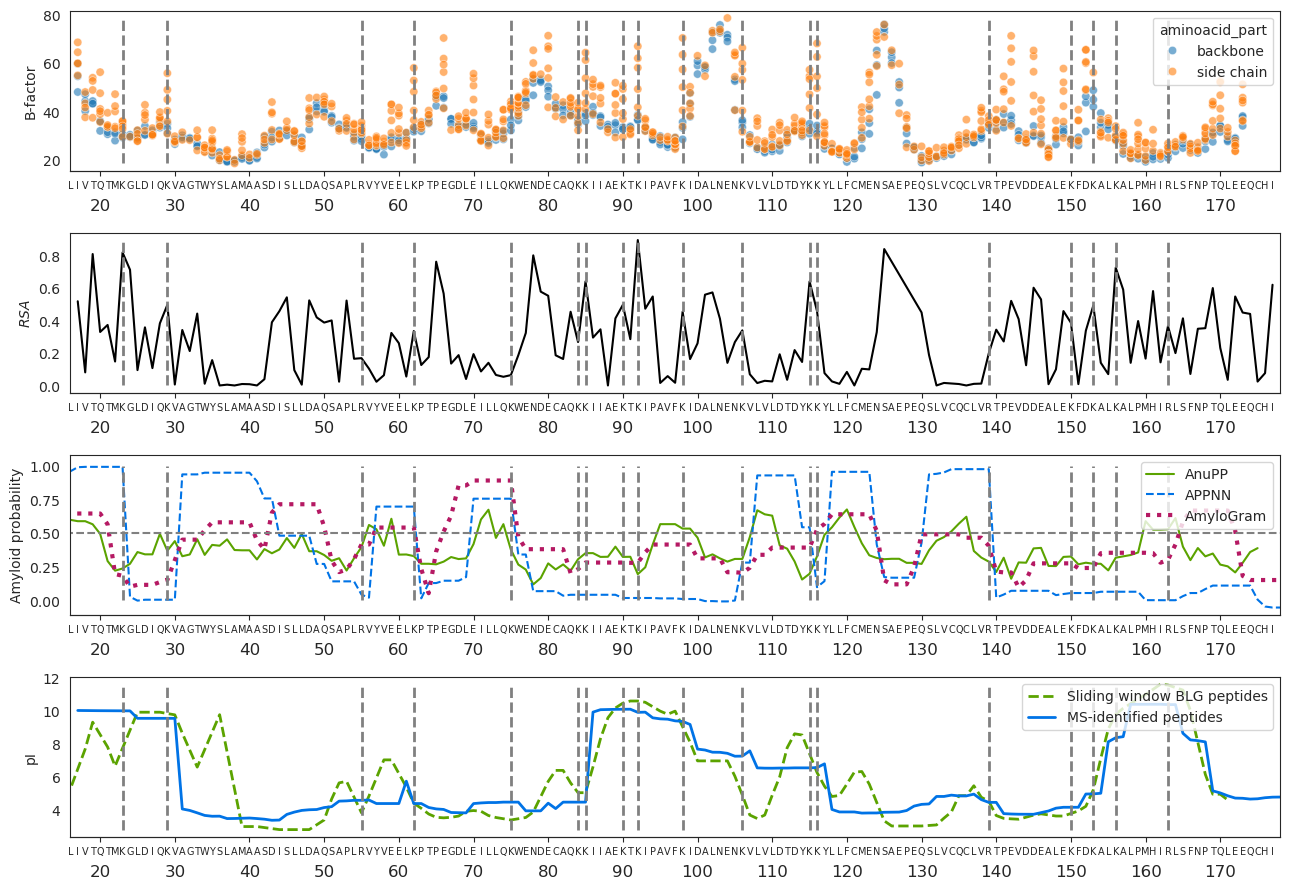

In [51]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=4, figsize=(13,9), height_ratios=[1,1,1,1])
    
    # B factors
    axes[0] = sns.scatterplot(
        b_factor,
        x='position', y='B-factor', hue='aminoacid_part',
        ax=axes[0], alpha=0.6
    )
    axes[0].set_ylabel('B-factor')
    axes[0].set_xlabel(None)
    axes[0].set_xticks(list(range(0,178)), list(blg_str), fontsize=7)
    sec = axes[0].secondary_xaxis(location=0)
    sec.set_xticks(list(range(10, 180,10)), ['\n' + str(i) for i in list(range(10, 180,10))], fontsize=12)
    axes[0].vlines(
        asa_tryptic,
        ymin=b_factor['B-factor'].min(), ymax=b_factor['B-factor'].max(),
        linestyles='dashed', color='grey', linewidth=2)
    
    # GRAVY
    # axes[1].plot('position', 'mean_gravy', data=pI_data, c='dimgray', label='gravy')
    # axes[1].scatter(
    #     asa_tryptic, pI_data.loc[pI_data['position'].isin(asa_tryptic), 'mean_gravy'], color='black',
    #     zorder=3
    # )
    # axes[1].set_ylabel('GRAVY')
    # axes[1].set_xticks(list(range(0,178)), list(blg_str), fontsize=7)
    # sec = axes[1].secondary_xaxis(location=0)
    # sec.set_xticks(list(range(10, 180,10)), ['\n' + str(i) for i in list(range(10, 180,10))], fontsize=12)

    # RASA
    axes[1].plot('pep_positions', 'r_asa', data=data_asa, label='RASA', c='black')
    axes[1].vlines(
        asa_tryptic,
        ymin=data_asa['r_asa'].min(), ymax=data_asa['r_asa'].max(),
        linestyles='dashed', color='grey', linewidth=2)
    # axes[2].vlines(
    #     asa_tryptic,
    #     ymin=data_asa['r_asa'].min(), ymax=data_asa['r_asa'].min()+(data_asa['r_asa_mean'].max()-data_asa['r_asa_mean'].min())/9,
    #     linestyles='solid', color='k')
    
    axes[1].set_ylabel('$RSA$')
    axes[1].set_xticks(list(range(0,178)), list(blg_str), fontsize=7)
    sec = axes[1].secondary_xaxis(location=0)
    sec.set_xticks(list(range(10, 180,10)), ['\n' + str(i) for i in list(range(10, 180,10))], fontsize=12)
    
    # Amyloid
    axes[2].plot('position', 'Score', data=anupp, label='AnuPP', c='#5ba300', linestyle='-')
    axes[2].plot('position', 'prediction', data=appnn, label='APPNN', c='#0073e6', linestyle='--')
    axes[2].plot('position', 'Probability', data=amylogram, label='AmyloGram', c='#b51963', linewidth=3, linestyle=':')
    axes[2].hlines(0.5, xmin=0, xmax=178, linestyles='dashed', color='grey')
    axes[2].vlines(
        asa_tryptic,
        ymin=0, ymax=1,
        linestyles='dashed', color='grey', linewidth=2)
    axes[2].set_xticks(list(range(0,178)), list(blg_str), fontsize=7)
    sec = axes[2].secondary_xaxis(location=0)
    sec.set_xticks(list(range(10, 180,10)), ['\n' + str(i) for i in list(range(10, 180,10))], fontsize=12)
    axes[2].set_ylabel('Amyloid probability')
    
    ## Isoelectric point
    axes[3].plot(
        'position', 'mean_pI', data=pI_data, c='#5ba300', linewidth=2, linestyle='--',
        label='Sliding window BLG peptides')
    axes[3].plot(
        'pep_positions', 'mean_pI', data=pos_counts_test, c='#0073e6', linewidth=2, linestyle='-',
        label='MS-identified peptides')
    axes[3].vlines(
        asa_tryptic,
        ymin=pI_data['mean_pI'].min(), ymax=pI_data['mean_pI'].max(),
        linestyles='dashed', color='grey', linewidth=2)
    axes[3].set_ylabel('pI')
    axes[3].set_xticks(list(range(0,178)), list(blg_str), fontsize=7)
    sec = axes[3].secondary_xaxis(location=0)
    sec.set_xticks(list(range(10, 180,10)), ['\n' + str(i) for i in list(range(10, 180,10))], fontsize=12)
    
    for ax in axes:
        ax.set_xlim([16,178])
        
    h1, l1 = axes[0].get_legend_handles_labels()
    h2, l2 = axes[1].get_legend_handles_labels()
    h3, l3 = axes[2].get_legend_handles_labels()
    # axes[0].legend(h1+h2+h3, l1+l2+l3, loc='upper left')
    axes[2].legend(loc='upper right')
    axes[3].legend(loc='upper right')
    # ax.legend()
    # ax.set_xlabel('Peptide Positions')
    # ax.set_ylabel('Isoelectric point')
    # sns.scatterplot(pos_counts_test, x='pep_positions', y='mean_pI_ma', ax=axes[1])
    fig.tight_layout()
    fig.savefig(os.path.join(project, 'analysis_results', 'pep_properties', 'pep_properties.png'))

# PSMs counts
Plot fraction of identified spectra by FDR

In [14]:
sns.set_style("white")
def export_legend(legend, filename="legend.png"):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename + '.svg', dpi=400, bbox_inches=bbox, format='svg')
    fig.savefig(filename + '.png', dpi=400, bbox_inches=bbox, format='png')


def plot_psms_by_fdr(data, n_scans=None, rel=True, **kwargs):
    if rel:
        yfield = 'f_psm'
    else:
        yfield = 'n_psm'

    if n_scans is not None:
        n_scans = n_scans.sort_values('Sample')
    p1 = sns.relplot(
        data=data, x='fdr', y=yfield, hue='DB', col='Engine', row='Sample', kind='line',
        linewidth = 6, style='Digestion', style_order=digestion_dashes.keys(),
        facet_kws={'sharey': 'row', 'margin_titles': True, 'legend_out': True}, **kwargs)
    # p1.set(xlabel ="FDR", ylabel = "Fraction of spectra")
    p1.set_xlabels("FDR", size=18)
    p1.set_ylabels("Fraction of identified spectra", size=18)
    p1.set_xticklabels(size=14)
    p1.set_titles(size=16)
    # p1.figure.tight_layout()
    export_legend(p1.legend, os.path.join(project, 'analysis_results', 'psms_counts', 'psms_legend'))
    p1.legend.remove()
    for i in range(len(p1.axes)):
        for j in range(len(p1.axes[i,:])):
            ylim = p1.axes[i,j].get_ylim()
            p1.axes[i,j].vlines([0.01, 0.05], ylim[0], ylim[1], linestyles='dashed', linewidth=3)
            p1.axes[i,j].set_xscale('log')
            if n_scans is not None:
                tot_scans = n_scans.iloc[i,2]
                p1.axes[i,j].text(0.08, 0.75, f'Scans: {tot_scans}', transform=p1.axes[i,j].transAxes,
                                  size=16, weight='demi')
            yt = p1.axes[i,0].get_yticks()
            ytl = p1.axes[i,0].get_yticklabels()
            p1.axes[i,0].set_yticks(yt, ytl, size=14)
            p1.axes[i,j].set_ylim(-0.01, ylim[1])
    # p1.set_yticklabels(size=14)
    return p1

In [15]:
# software = software[1:]
software = ['Mascot', 'MaxQuant', 'Metamorpheus', 'Fragpipe', 'pFind']

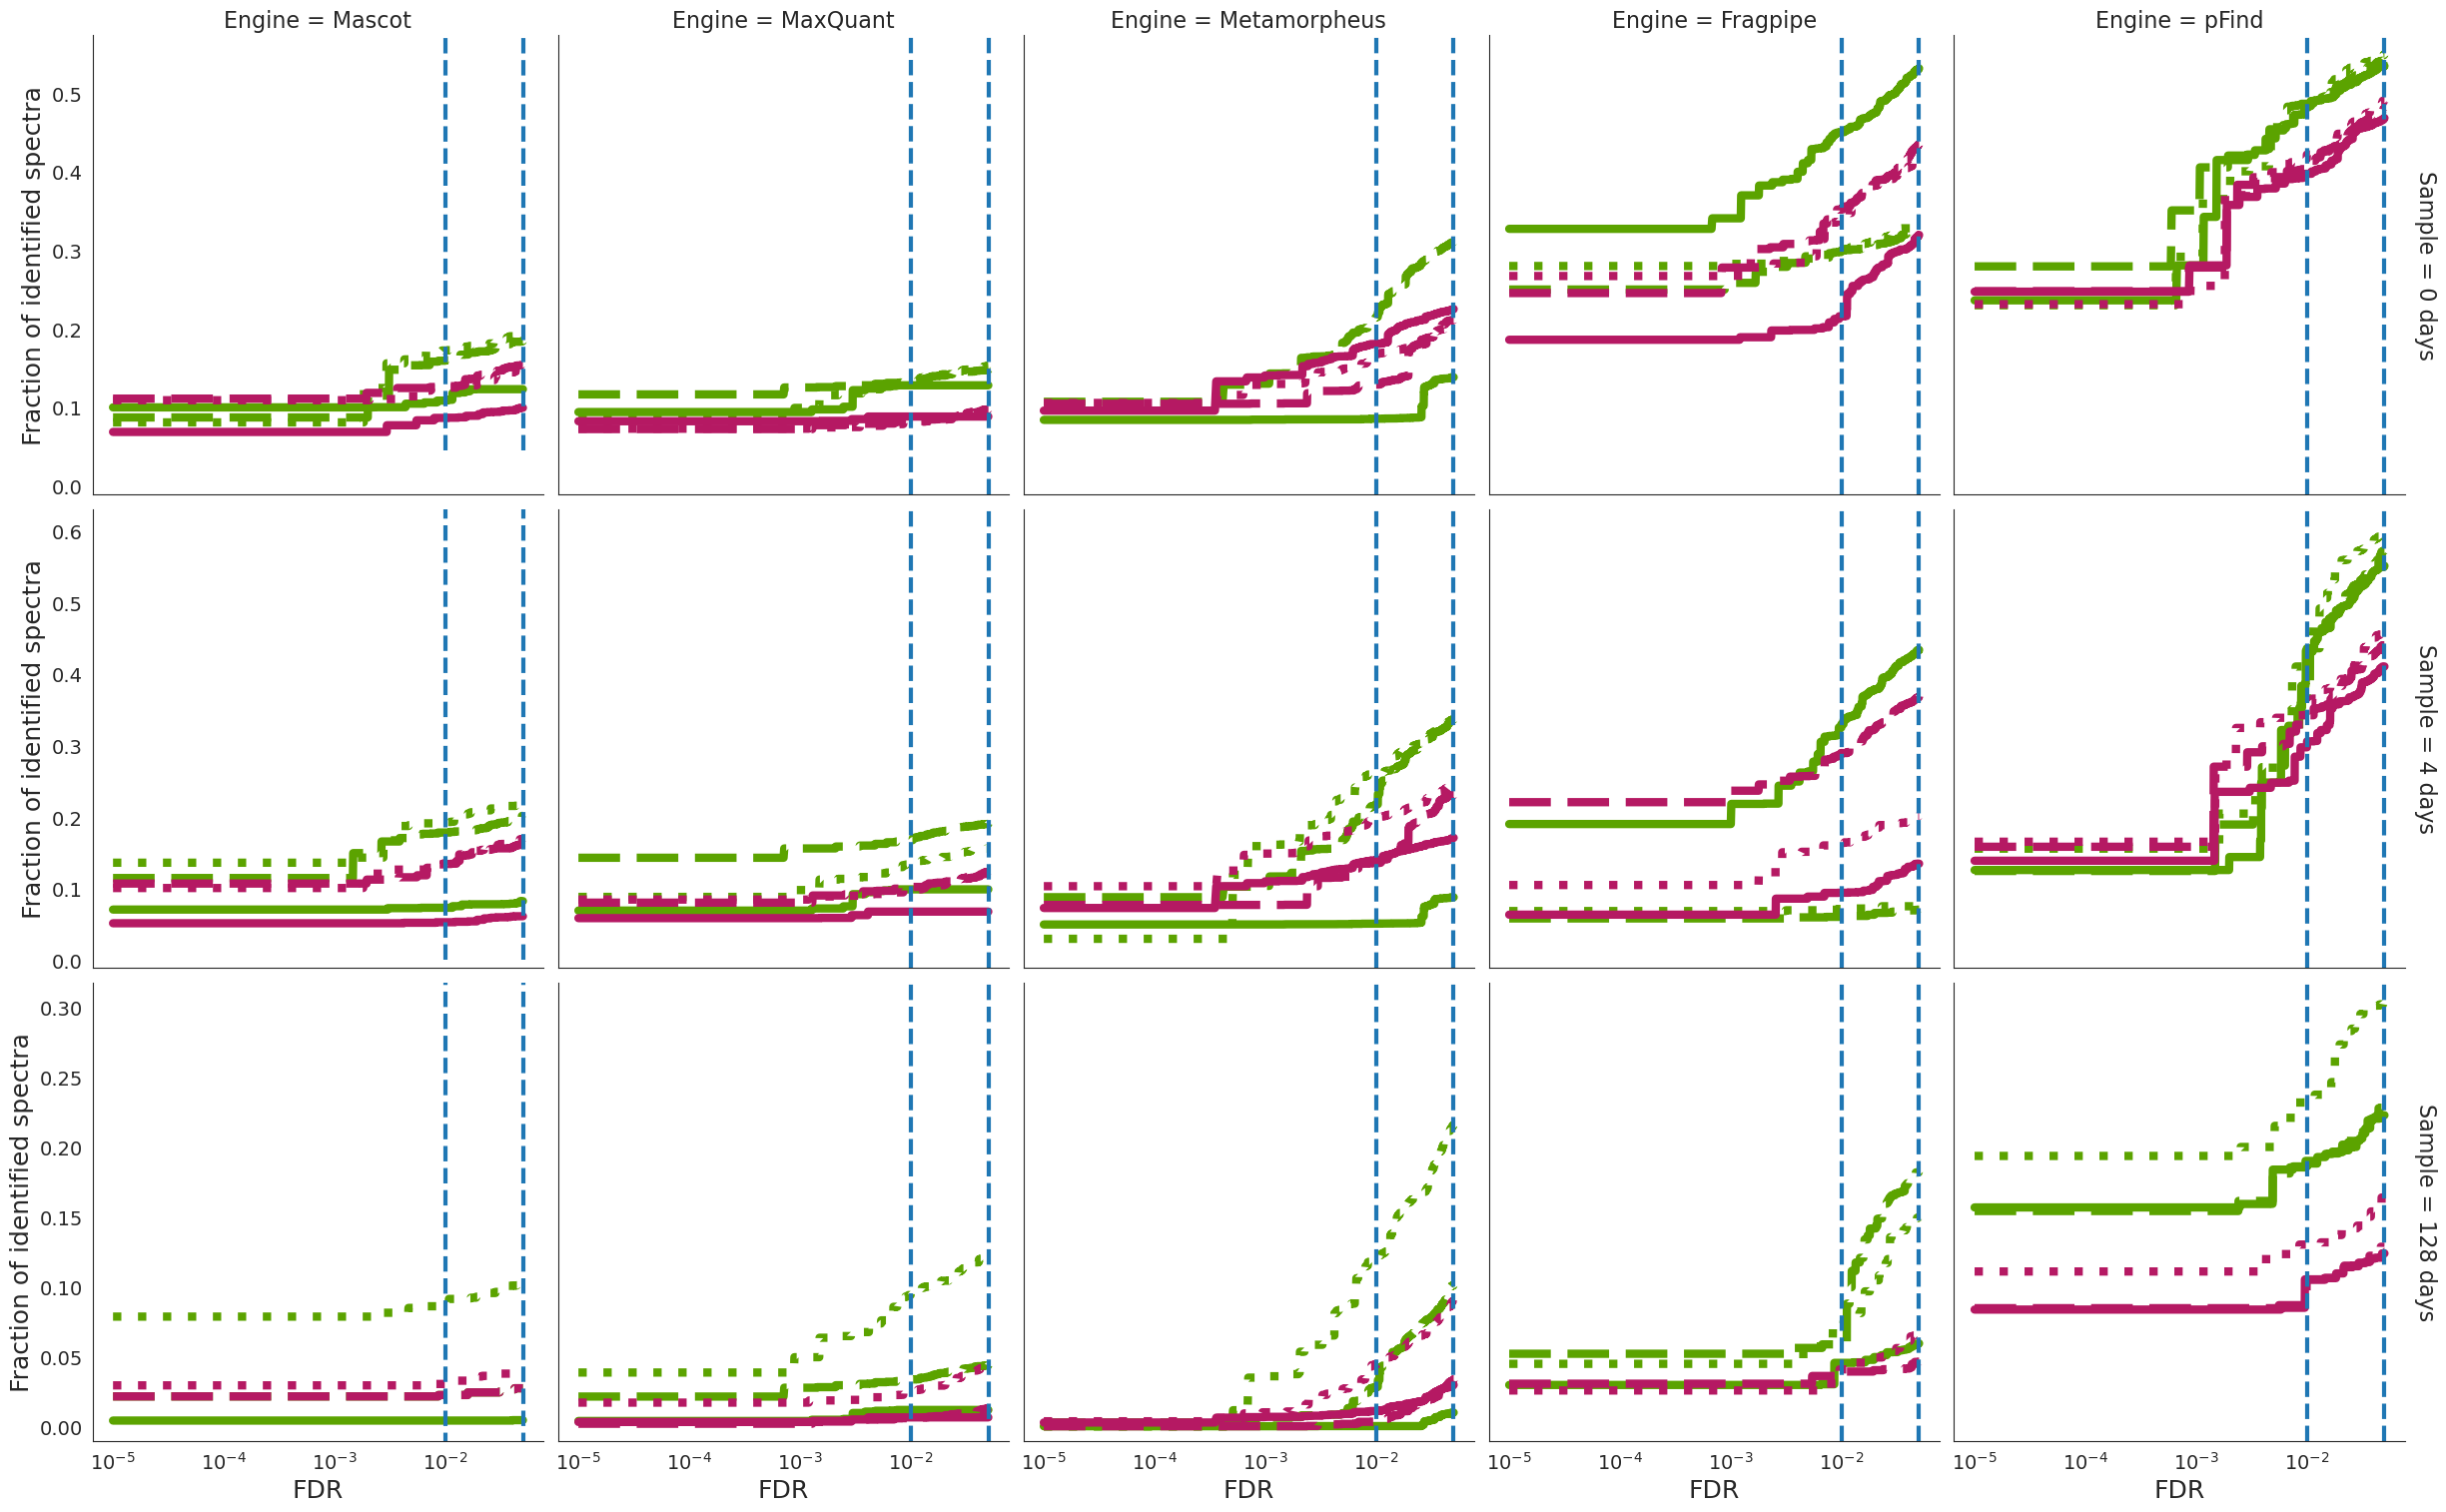

In [16]:
psms_counts_fig = plot_psms_by_fdr(
    psm_counts_df, n_scans=None, rel=True, col_order=software,
    palette=db_colors, dashes=digestion_dashes)
psms_counts_fig

In [17]:
psms_counts_fig.savefig(os.path.join(project, 'analysis_results', 'psms_counts', 'test_psms_counts.png'), dpi=400)
psms_counts_fig.savefig(os.path.join(project, 'analysis_results', 'psms_counts', 'test_psms_counts.svg'), dpi=400, format='svg')

# Venn Diagrams on peptides

In [ ]:
def get_run_labels(run_ids, benchmark_table):
    run_labels = (
        benchmark_table[['Run_id', 'Run settings']]
        .query('Run_id in @run_ids')
        .set_index('Run_id').loc[run_ids,'Run settings'].values)
    return run_labels

def plot_venn_pepts(data, samples, runs, circle_labels=None, venn_labels=None, venn_by='samples'):
    if venn_by == 'samples':
        outer = 'Sample'
        inner = 'Run_id'
        venn_var = samples
        circle_var = runs
    elif venn_by == 'runs':
        outer = 'Run_id'
        inner = 'Sample'
        venn_var = runs
        circle_var = samples
    else:
        raise ValueError(f"venn_by value {venn_by} not valid")
    if circle_labels is None:
        circle_labels = circle_var
    if venn_labels is None:
        venn_labels = venn_var

    figure, axes = plt.subplots(1, len(venn_var), figsize=(15, 7))
    for i, v in enumerate(venn_var):
        set_list = []
        for c in circle_var:
            set_list.append(set(data.query(f'{outer} == @v and {inner} == @c').Seq))
        v = venn3(set_list, set_labels=circle_labels, ax = axes[i])
        axes[i].text(0.2, 1.1, f'{outer}: {venn_labels[i]}', transform=axes[i].transAxes,
                     size=12, weight='demi')
        for c in ('A', 'B', 'C'):
            v.get_label_by_id(c).set(fontsize=12)
    figure.tight_layout()
    return figure


In [ ]:

fp_venn_runs = ['fp_t_db1', 'fp_st_db1', 'fp_ns_db1']
fp_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], fp_venn_runs,
    circle_labels = get_run_labels(fp_venn_runs, benchmark_table),
    venn_by='samples'
)
fp_venn.savefig(os.path.join(project, 'analysis_results', 'fragpipe_venn.png'), format='png', dpi=400)
fp_venn.savefig(os.path.join(project, 'analysis_results', 'fragpipe_venn.svg'), format='svg', dpi=400)


pfind_venn_runs = ['pf_t_db1', 'pf_st_db1', 'pf_ns_db1']
pfind_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], pfind_venn_runs,
    circle_labels = get_run_labels(pfind_venn_runs, benchmark_table),
    venn_by='samples'
)
pfind_venn.savefig(os.path.join(project, 'analysis_results', 'pfind_venn.png'), format='png', dpi=400)
pfind_venn.savefig(os.path.join(project, 'analysis_results', 'pfind_venn.svg'), format='svg', dpi=400)


mm_venn_runs = ['mm_t_db1', 'mm_st_db1', 'mm_ns_db1']
mm_venn = plot_venn_pepts(
    psm_data_df.query('q <= 0.01'),
    ['N0000', 'N0040', 'N1280'], mm_venn_runs,
    circle_labels = get_run_labels(mm_venn_runs, benchmark_table),
    venn_by='samples'
)
mm_venn.savefig(os.path.join(project, 'analysis_results', 'mm_venn.png'), format='png', dpi=400)
mm_venn.savefig(os.path.join(project, 'analysis_results', 'mm_venn.svg'), format='svg', dpi=400)
